VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a GP-VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import sys
import os

# Add the parent directory to sys.path to find the libs module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
print(f"Added {parent_dir} to Python path")
print(f"Current working directory: {os.getcwd()}")
print(f"Python path: {sys.path}")

Added /home/benjamin.deporte/MVA/MVA_Stage to Python path
Current working directory: /home/benjamin.deporte/MVA/MVA_Stage/notebooks
Python path: ['/home/benjamin.deporte/MVA/MVA_Stage/notebooks', '/home/benjamin.deporte/.conda/envs/torchy/lib/python312.zip', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/lib-dynload', '', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/setuptools/_vendor', '/home/benjamin.deporte/MVA/MVA_Stage']


In [3]:
from libs.gpvae_lib import seed_everything
from libs.gpvae_lib import Encoder, GaussianDecoder, GaussianProcessPriorMaison, EncoderMean
from libs.gpvae_lib import DecoderMean, make_mlp, GPNullMean, compute_vlb, kl_maison
from libs.gpvae_lib import CauchyKernel, RQKernel, MaternKernel # GaussianKernel, 
from libs.gpvae_lib import compute_vlb

In [4]:
# Set seed for reproducibility
seed_everything(42)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Data simplissime

In [6]:
# Dimensions
Dx = 1
Dz = 1

# parameters
N = 100
B = 1

t shape: torch.Size([1, 100])
x shape: torch.Size([1, 100])


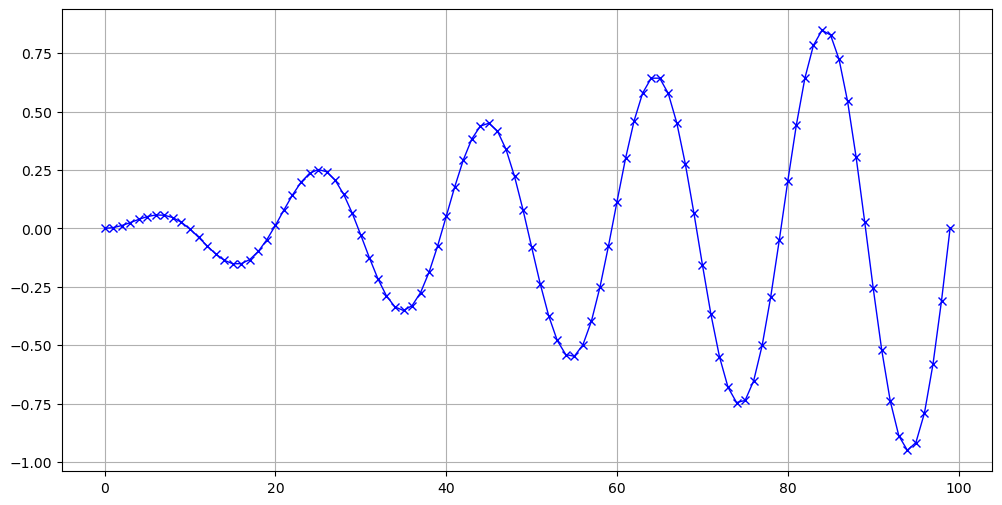

In [7]:
t = torch.linspace(0, 1, N).reshape(1, N).to(device)  # (1, N)
print(f"t shape: {t.shape}")  # (1, N)
x = t * torch.sin(t * 2 * np.pi * 5)
# x = t * torch.sin(t * 2 * np.pi * t)
print(f"x shape: {x.shape}") # (1, N)

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series
ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
ax.grid(True)
plt.show()# Data simplissime

# Modèle

Encoder

### NB : l'implémentation de l'encoder covariance dans gpvae_lib (diagonale + triangulaire inférieure) ne semble pas permettre d'apprendre le prior GP

In [8]:
class EncoderPrecision(nn.Module):
    """Reprise de l'implémentation du papier GPVAE avec
    matrice de précision triangulaire supérieure à deux bandes
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 2,
                 inter_dim = 32,
                 activation = nn.ReLU,
                 epsilon = 1e-3
                 ):
        
        super(EncoderPrecision, self).__init__()
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon) 
        
        self.diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        self.off_diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
    def forward(self, x):
        """
        x : (B, N, Dx)
        return : (B, Dz, Dz)
        """
        N = x.size(-1)
        
        # Compute the diagonal part
        D = self.diagonal_mlp(x) # (B, N, Dz)
        # print(f"in Encoder Precision : D version sortie MLP : {D._version}")
        D = torch.transpose(D, -1, -2)  # (B, Dz, N)
        D = torch.exp(D) # ensure > 0
        D = torch.diag_embed(D) # (B, Dz, N, N)
        # print(f"in Encoder Precision : D après traitement : {D._version}")
        
        # compute the upper band
        U = self.off_diagonal_mlp(x) # (B, N, Dz)
        # print(f"in Encoder Precision : U version sortie MLP : {U._version}")
        U = torch.transpose(U, -1, -2)  # (B, Dz, N)
        # print(f"in Encoder Precision : U version apres transpose : {U._version}")
        U = torch.diag_embed(U[...,:-1], offset=1)  # (B, Dz, N, N)
        # print(f"in Encoder Precision : U version apres diag_embed : {U._version}")
        
        # Combine diagonal and upper band
        B = D + U # (B, Dz, N, N)

        precision_matrix = torch.transpose(B, -1, -2) @ B  # (B, N, Dz, Dz)
        # print(f"in Encoder Precision : precision matrix version après transpose : {precision_matrix._version}")
        
        precision_matrix = precision_matrix + self.epsilon * torch.eye(N, device=device).reshape(1, 1, N, N)  # Add epsilon to the diagonal
        # print(f"in Encoder Precision : precision matrix version après + identity : {precision_matrix._version}")
        
        return D, B, precision_matrix  # (B, Dz, N, N)
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(x_dimension={self.x_dimension}, "
                f"z_dimension={self.z_dimension}, n_layers={self.n_layers}, "
                f"inter_dim={self.inter_dim}, activation={self.activation.__name__}, "
                f"epsilon={self.epsilon})")

In [9]:
encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

a = torch.randn(1, 10, 1).to(device)  # (B, N, Dx)
D, B, precision_matrix = encoder_precision(a)
print(f"D shape: {D.shape}")  # (B, Dz, N, N)
print(f"B shape: {B.shape}")  # (B, Dz, N, N)
print(f"Precision matrix shape: {precision_matrix.shape}")  # (B, N, Dz, Dz)

D shape: torch.Size([1, 1, 10, 10])
B shape: torch.Size([1, 1, 10, 10])
Precision matrix shape: torch.Size([1, 1, 10, 10])


In [10]:
encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

In [11]:
# encoder = Encoder(
#     x_dimension=Dx,
#     z_dimension=Dz,
#     n_layers=2,
#     inter_dim=16,
#     activation=nn.ReLU,
#     epsilon=1e-12
# ).to(device)

# print(encoder)

Decoder

In [12]:
decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_logvar)

DecoderMean x_dimension=1, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU
Sequential(
  (0): Linear(in_features=100, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=100, bias=True)
)


Prior Gaussian Process

In [ ]:
# Copied from libs/gpvae_lib pour debugger

class GaussianKernel(nn.Module):  
    """Gaussian kernel for one univariate Gaussian Process.
    The lengthscale and variance parameters are learnable (nn.Parameter).
    """
    
    # we need to add a small positive constant to ensure positive definiteness of the kernel matrix
    # 1e-3 is ok for time series up to 10,000 time points.
    # 1e-4 is ok for time series up to 2,880 time points. (ie 2 days @ 1 minute resolution).
    # 1e-4 is ok for time series up to 1,000 time points.
    # 1e-6 is ok for time series up to 100 time points.
    # the value can be decreased for shorter time series.
    # but it should not be too small, otherwise the Cholesky decomposition will fail.
    
    def __init__(self, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(GaussianKernel, self).__init__()
        
        # learnable parameters for the Gaussian kernel
        self.lengthscale = nn.Parameter(torch.tensor(lengthscale))  # learnable lengthscale parameter       
        self.sigma = nn.Parameter(torch.tensor(sigma))  # learnable variance parameter
        
        self.epsilon = torch.tensor(epsilon)  # tolerance to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Gaussian kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "GaussianKernel object : Input tensors must have the same number of dimensions"
        
        # compute the Gaussian kernel matrix
        #
        # --- IL Y AURAIT ICI UNE INPLACE OPERATION
        #
        #
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (...,N, 1)
            t2_b = t2.unsqueeze(-2) # (...,1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (..., N, M)
            
        gaussian_kernel_matrix = self.sigma**2 * kernel  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            gaussian_kernel_matrix = gaussian_kernel_matrix + self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(gaussian_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return gaussian_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed. Tolerance alpha is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return gaussian_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(lengthscale={self.lengthscale.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"epsilon={self.epsilon.item():.3e})")      


In [14]:
class FixedGaussianKernel(nn.Module):  
    """Gaussian kernel for one univariate Gaussian Process.
    The lengthscale and variance parameters are NOT learnable here.
    """
    
    # we need to add a small positive constant to ensure positive definiteness of the kernel matrix
    # 1e-3 is ok for time series up to 10,000 time points.
    # 1e-4 is ok for time series up to 2,880 time points. (ie 2 days @ 1 minute resolution).
    # 1e-4 is ok for time series up to 1,000 time points.
    # 1e-6 is ok for time series up to 100 time points.
    # the value can be decreased for shorter time series.
    # but it should not be too small, otherwise the Cholesky decomposition will fail.
    
    def __init__(self, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(FixedGaussianKernel, self).__init__()
        
        # learnable parameters for the Gaussian kernel
        self.lengthscale = torch.tensor(lengthscale)  # lengthscale parameter       
        self.sigma = torch.tensor(sigma)  # sigma parameter (variance = sigma**2)
        
        self.epsilon = torch.tensor(epsilon)  # tolerance to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Gaussian kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "GaussianKernel object : Input tensors must have the same number of dimensions"
        
        # compute the Gaussian kernel matrix
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (...,N, 1)
            t2_b = t2.unsqueeze(-2) # (...,1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (..., N, M)
            
        gaussian_kernel_matrix = self.sigma**2 * kernel  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            gaussian_kernel_matrix += self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(gaussian_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return gaussian_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed. Tolerance alpha is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return gaussian_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(lengthscale={self.lengthscale.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"epsilon={self.epsilon.item():.3e})")      

In [15]:
class FixedRQKernel(nn.Module):
    """Rational Quadratic kernel for one univariate Gaussian Process.
    The lengthscale, variance and alpha parameters are NOT learnable.
    """
    
    def __init__(self, alpha=1.0, beta=1.0, sigma=1.0, epsilon=1e-3):
        super(FixedRQKernel, self).__init__()
        
        # learnable parameters for the RQ kernel
        self.alpha = torch.tensor(alpha)  # alpha parameter (shape parameter)
        self.beta = torch.tensor(beta)  # beta parameter       
        self.sigma = torch.tensor(sigma)  # variance = sigma**2 parameter

        self.epsilon = epsilon  # small value to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Rational Quadratic kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "RQKernel object : Input tensors must have the same number of dimensions"
        
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            mat = 1 + ((t1_b - t2_b)**2 / (2 * self.alpha / self.beta)) # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (..., N, 1)
            t2_b = t2.unsqueeze(-2) # (..., 1, M)
            mat = 1 + ((t1_b - t2_b)**2 / (2 * self.alpha / self.beta))  # (N, M)
            
        rq_kernel_matrix = self.sigma**2 * mat**(-self.alpha)  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            rq_kernel_matrix += self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(rq_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return rq_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed in RQKernel. Tolerance epsilon is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return rq_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(alpha={self.alpha.item():.3e}, "
                f"beta={self.beta.item():.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"epsilon={self.epsilon:.3e})")     

In [16]:
prior_mean = GPNullMean()
print(prior_mean)

prior_kernel = GaussianKernel(
    lengthscale=0.1,
    sigma=1.0,
    epsilon=1e-12
)
print(prior_kernel)

GPNullMean
GaussianKernel(lengthscale=1.000e-01, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)


# Training

Encode Time Series

In [17]:
x_ext = x.unsqueeze(-1)  # (B, N, Dx)
print(f"x_ext shape: {x_ext.shape}")  # (1, N, 1)

x_ext shape: torch.Size([1, 100, 1])


In [18]:
mu_phi = encoder_mean(x_ext)  # (B, Dz, N)
_, _, precision_phi = encoder_precision(x_ext)  # (B, Dz, N, N)

mu_phi = mu_phi.squeeze(0)  # (N, Dz)
precision_phi = precision_phi.squeeze(0)  # (N, Dz, Dz)

q_phi = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (B, N, Dz)
    precision_matrix=precision_phi,  # (B, N, Dz, Dz)
)

print(f"mu_phi shape: {mu_phi.shape}")
print(f"sigma_phi shape: {precision_phi.shape}")
print(f"q_phi: {q_phi}")
print(f"\tq_phi batch shape: {q_phi.batch_shape}")
print(f"\tq_phi event shape: {q_phi.event_shape}")

mu_phi shape: torch.Size([1, 100])
sigma_phi shape: torch.Size([1, 100, 100])
q_phi: MultivariateNormal(loc: torch.Size([1, 100]), precision_matrix: torch.Size([1, 100, 100]))
	q_phi batch shape: torch.Size([1])
	q_phi event shape: torch.Size([100])


In [19]:
# mu_phi, sigma_phi, _ = encoder(x_ext)

# mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
# sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

# q_phi = torch.distributions.MultivariateNormal(
#     loc=mu_phi,  # (B, N, Dz)
#     covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
# )

# print(f"mu_phi shape: {mu_phi.shape}")
# print(f"sigma_phi shape: {sigma_phi.shape}")
# print(f"q_phi: {q_phi}")
# print(f"\tq_phi batch shape: {q_phi.batch_shape}")
# print(f"\tq_phi event shape: {q_phi.event_shape}")

Sample latent

In [20]:
z_sampled = q_phi.rsample()  # (B, N)
print(f"z_sampled shape: {z_sampled.shape}")
z_sampled_ext = z_sampled.unsqueeze(-1)  # (B, N, Dz)
print(f"z_sampled_ext shape: {z_sampled_ext.shape}")

z_sampled shape: torch.Size([1, 100])
z_sampled_ext shape: torch.Size([1, 100, 1])


Decode the latent and sample $K$ x's

In [21]:
mu_x = decoder_mean(z_sampled_ext)  # (B, N, Dx)
mu_x = mu_x.squeeze(2)  # (B, N)
print(f"mu_x shape: {mu_x.shape}")

logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)
print(f"covar_x shape: {covar_x.shape}")

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)
print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

mu_x shape: torch.Size([1, 100])
covar_x shape: torch.Size([1, 100, 100])
p_theta_x: MultivariateNormal(loc: torch.Size([1, 100]), covariance_matrix: torch.Size([1, 100, 100]))
	p_theta_x batch shape: torch.Size([1])
	p_theta_x event shape: torch.Size([100])


In [22]:
K = 10 # number of samples to draw from the decoder distribution
x_sampled = p_theta_x.rsample((K,))  # (K, B, L, Dx)
print(f"x_samples shape ({K} samples): {x_sampled.shape}")

x_samples shape (10 samples): torch.Size([10, 1, 100])


Compute the Gaussian Process prior at times t's

In [23]:
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
    loc=mu_z,  # (N, Dz)
    scale_tril=L_z  # (N, N)
)

print(f"mu_z shape: {mu_z.shape}")
print(f"sigma_z shape: {sigma_z.shape}")
print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")

mu_z shape: torch.Size([1, 100])
sigma_z shape: torch.Size([1, 100, 100])
p_theta_z: MultivariateNormal(loc: torch.Size([1, 100]), scale_tril: torch.Size([1, 100, 100]))
	p_theta_z batch shape: torch.Size([1])
	p_theta_z event shape: torch.Size([100])


Compute the metrics and the loss

In [24]:
kl = torch.distributions.kl_divergence(q_phi, p_theta_z)  # (B, N)
print(f"kl shape: {kl.shape}")

reco_loss = -p_theta_x.log_prob(x)  # (B, N)
print(f"reco_loss shape: {reco_loss.shape}")

loss = - reco_loss.mean() + kl.mean()  # (B, N)
print(f"loss shape: {loss.shape}")
print(f"loss: {loss.item():.4e}")

kl shape: torch.Size([1])
reco_loss shape: torch.Size([1])
loss shape: torch.Size([])
loss: 1.9326e+13


In [25]:
kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    q_phi, p_theta_x, p_theta_z, x
)

loss = -vlb_value
print(f"Loss : {loss.item():.4e}")

Loss : 1.9326e+13


# Full Training Loop

## Très grande sensibilité au lengthscale !!

Résultats :
- N = 30, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 100, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 150, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation ReLU sur EncoderMean, activation Tanh sur EncoderPrecision : nok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation ReLU sur EncoderPrecison, activation Tanh sur EncoderMean : instable, marche au 3e run, peu reproductible.
- N = 200, l = entre 0.1 et 0.14, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok ! NE MARCHE PAS EN DEHORS DE CET INTERVALLE DE LENGTHSCALE
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256 avec Encoder Ben (lower triangular pour covariance Decoder), activation Tanh : ok ! Semble moins bon malgré tout qu'avec le bi-bande. Ne marche qu'avec l <= 0.12
- pas trouvé de set up qui marche avec RQ Kernel

Toujours avec N=200, l=0.10, 5000 epochs, GK, lr=1e-3, activation Tanh - on change le réseau Encoder Mean et Encoder Precision:
- 4 layers x 256 : ok
- 2 x 64 : nok
- 4 x 64 : nok
- 4 x 128 : nok
- EncoderPrecision 4x256, EncoderMean 2x32 : ok, mais moins bon qu'avec 4x256 et 4x256
- Precision 4x256, Mean 4x32 : nok !
- Precison 4x256, Mean 4x64 : nok !
- Precision 4x256, Mean 4x128 : nok !
- Precision 4x512, Mean 4x512 : ok, semble clipper vers les +/-1 (effet Tanh ?)

Toujours avec N=200, l=0.10, GK, lr=1e-3, activation Tanh, (4x256)x2 :
- 100 epochs : nok
- 1000 epochs : ça commence !
- 2000 epochs : idem 1000
- 3000 epochs : mieux...
- 4000 epochs : très bien, tb reconstruction - loss finale : 2.126e+7 (kl 2.1262e+7, reco -4.31e+2)
- 10000 epochs : moins bien ! - loss finale = 8.83e+5, kl = 8.83e+5, reco = -1.15e+2 : reconstruction instable, moins bonne à l'arrêt aux 10000 epochs.
- 100000 epochs : instabilités. Pas de reconstruction. - loss finale = 2.46e+2, kl = 3.04e+2, reco = -5.85e+1.

Changement de fonction : t sin (2 t²) par exemple => fail. Pb quand le lengthscale change.

In [26]:
# encoder = Encoder(
#     x_dimension=Dx,
#     z_dimension=Dz,
#     n_layers=4,
#     inter_dim=256,
#     activation=nn.Tanh,
#     epsilon=1e-12,
# ).to(device)

# print(encoder)
# print()

encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
).to(device)

print(encoder_mean)

encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh, 
    epsilon=1e-12
).to(device)

print(encoder_precision)

decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=4,
    inter_dim=256,
    activation=nn.ReLU,
).to(device)

print(decoder_logvar)

print()
prior_mean = GPNullMean()
print(prior_mean)

# prior_kernel = FixedGaussianKernel(
#     epsilon=1e-12,  # small value to ensure positive definiteness of the kernel matrix
#     lengthscale=0.10,  # lengthscale parameter 
# )

prior_kernel = GaussianKernel(
    lengthscale=0.1,
    sigma=1.0,
    epsilon=1e-12
)
print(prior_kernel)

# prior_kernel = FixedRQKernel(
#     epsilon=1e-12,  # small value to ensure positive definiteness of the kernel matrix
#     alpha=0.5,
#     beta=10.0,
#     sigma=1.0,
# )
# print(prior_kernel)

x_ext = x.unsqueeze(-1)  # (B, N, Dx)
print(f"x_ext shape: {x_ext.shape}")  # (1, N, 1)

EncoderMean, x_dimension=1, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh
EncoderPrecision(x_dimension=1, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh, epsilon=1e-12)
DecoderMean x_dimension=1, z_dimension=1, n_layers=4, inter_dim=256, activation=ReLU
Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=100, bias=True)
)

GPNullMean
GaussianKernel(lengthscale=1.000e-01, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)
x_ext shape: torch.Size([1, 100, 1])


In [27]:
N_EPOCHS = int(3)

# NB : list(prior_kernel.parameters()) is empty since FixedGaussianKernel has no learnable parameters
# optimizer = torch.optim.Adam(
#     list(encoder.parameters()) + list(decoder_mean.parameters()) + list(decoder_logvar.parameters()) +
#     list(prior_mean.parameters()) + list(prior_kernel.parameters()),
#     lr = 1e-3
# )

optimizer = torch.optim.Adam(
    list(encoder_mean.parameters()) + list(encoder_precision.parameters())+ list(decoder_mean.parameters()) + list(decoder_logvar.parameters()) +
    list(prior_mean.parameters()) + list(prior_kernel.parameters()),
    lr = 1e-3
)

# number of samples to draw from the decoder distribution
K = 10 

# tolerance for covariance matrix
epsilon = 1e-12
id = torch.eye(N, device=device).unsqueeze(0)  # (1, N, N)

In [28]:
losses = []
kls = []
reconstruction_losses = []

# dictionnary to store the parameters
mean_params = {}  # to store mean parameters if any
for name, param in prior_mean.named_parameters():
    mean_params[name] = []
    
kernel_params = {}  # to store kernel parameters if any
for name, param in prior_kernel.named_parameters():
    kernel_params[name] = []

Regarder 

https://docs.pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#operations

https://medium.com/@rizqinur2010/pytorch-in-place-operations-bfde2f171afa

pour les inplace operations, et les problemes de double computation du graphe backward

In [29]:
torch.autograd.set_detect_anomaly(True)

# prior
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
        loc=mu_z,  # (N, Dz)
        scale_tril=L_z  # (N, N)
    )

for epoch in range(N_EPOCHS):
    
    # encode
    # mu_phi, sigma_phi, _ = encoder(x.unsqueeze(-1))

    # mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
    # sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

    # q_phi = torch.distributions.MultivariateNormal(
    #     loc=mu_phi,  # (B, N, Dz)
    #     covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
    # )
    
    mu_phi = encoder_mean(x_ext)  # (B, Dz, N)
    _, _, precision_phi = encoder_precision(x_ext)  # (B, Dz, N, N)

    mu_phi = mu_phi.squeeze(0)  # (N, Dz)
    precision_phi = precision_phi.squeeze(0)  # (N, Dz, Dz)

    q_phi = torch.distributions.MultivariateNormal(
        loc=mu_phi,  # (B, N, Dz)
        precision_matrix=precision_phi,  # (B, N, Dz, Dz)
    )
    
    # sample z
    z_sampled = q_phi.rsample()
    
    # decode
    mu_x = decoder_mean(z_sampled.unsqueeze(-1))  # (B, N, Dx)
    mu_x = mu_x.squeeze(2)  # (B, N)

    logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
    covar_x = torch.diag_embed(logvar_x.exp()) + epsilon * id  # (B, N, Dx, Dx)

    p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    )
    
    # # sample from decoder
    # x_hat = p_theta_x.rsample((K,))  # (K, B, L, Dx)
    
    # compute loss
    kl = torch.distributions.kl_divergence(q_phi, p_theta_z).sum(-1).mean()  # (B, N)
    # print(f"q_phi loc version : {q_phi.loc._version}")
    # print(f"p_theta_z loc version : {p_theta_z.loc._version}")
    # print(f"q_phi precision version : {q_phi.precision_matrix._version}")
    # print(f"p_theta_z precision version : {p_theta_z.precision_matrix._version}")
    # print(f"q_phi covariance version : {q_phi.covariance_matrix._version}")
    # print(f"p_theta_x covariance version : {p_theta_x.covariance_matrix._version}")

    # reconstruction_loss = p_theta_x.log_prob(x).sum(-1).mean()
    reconstruction_loss = torch.tensor(0.0, device=device)  # (B, N)
    # print(f"q_phi loc version : {q_phi.loc._version}")
    # print(f"p_theta_z loc version : {p_theta_z.loc._version}")
    # print(f"q_phi precision version : {q_phi.precision_matrix._version}")
    # print(f"p_theta_z precision version : {p_theta_z.precision_matrix._version}")
    # print(f"q_phi covariance version : {q_phi.covariance_matrix._version}")
    # print(f"p_theta_x covariance version : {p_theta_x.covariance_matrix._version}")
    
    loss = -reconstruction_loss + kl  # (B, N)

    # kl, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    #     q_phi, p_theta_x, p_theta_z, x
    # )
    
    # print(f"loss version : {loss._version}")
    # print(f"reconstruction_loss version : {reconstruction_loss._version}")
    # print(f"kl version : {kl._version}")
    
    print(f"mu_z version : {mu_z._version}")
    print(f"sigma_z version : {sigma_z._version}")
    print(f"L_z version : {L_z._version}")
    print(f"p_theta_z loc version : {p_theta_z.loc._version}")
    print(f"p_theta_z covariance version : {p_theta_z.covariance_matrix._version}")
    
        
    # optimization step
    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # retain_graph=True to allow multiple backward passes
    optimizer.step()
    
    # log losses
    losses.append(loss.item())
    kls.append(kl.mean().item())
    reconstruction_losses.append(-reconstruction_loss.mean().item())
    
    # record parameters
    for name, param in prior_mean.named_parameters():
        mean_params[name].append(param.item())
    for name, param in prior_kernel.named_parameters():
        kernel_params[name].append(param.item())
        
    # print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{N_EPOCHS}], Loss: {loss.item():.4e}, "
              f"KL: {kl.mean().item():.4e}, "
              f"Reconstruction Loss: {-reconstruction_loss.mean().item():.4e}")

mu_z version : 0
sigma_z version : 0
L_z version : 0
p_theta_z loc version : 0
p_theta_z covariance version : 0
Epoch [1/3], Loss: 3.1669e+13, KL: 3.1669e+13, Reconstruction Loss: -0.0000e+00
mu_z version : 0
sigma_z version : 0
L_z version : 0
p_theta_z loc version : 0
p_theta_z covariance version : 0


/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/torch/autograd/graph.py:768: UserWarning: Error detected in DivBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/asyncio/bas

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.DoubleTensor []] is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

ax[0].plot(losses, label='Loss', color='blue')
ax[0].set_title('Loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(kls, label='KL Divergence', color='orange')
ax[1].set_title('KL Divergence over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('KL Divergence')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].legend()

ax[2].plot(reconstruction_losses, label='Reconstruction Loss', color='green')
ax[2].set_title('Reconstruction Loss over epochs')
ax[2].set_xlabel('Epochs')      
ax[2].set_ylabel('Reconstruction Loss')
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# for name, values in prior_mean.named_parameters():
#     plt.plot(mean_params[name], label=name)
#     plt.ttile(f'Prior Mean Parameter: {name}')
# # plt.title('Prior Mean Parameters over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Parameter Value')
# plt.grid(True)
# plt.show()

In [ ]:
for name, values in prior_kernel.named_parameters():
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(kernel_params[name], label=name)
    ax.set_title(f'Kernel Prior Parameter: {name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Parameter Value')
    ax.grid(True)
    plt.show()

Predictions

In [ ]:
z_sampled = q_phi.rsample()  # (B, N)
print(f"z_sampled shape: {z_sampled.shape}")
z_sampled_ext = z_sampled.unsqueeze(-1)  # (B, N, Dz)
print(f"z_sampled_ext shape: {z_sampled_ext.shape}")

In [ ]:
mu_x = decoder_mean(z_sampled_ext)  # (B, N, Dx)
mu_x = mu_x.squeeze(2)  # (B, N)

logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)

p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    )

print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

In [ ]:
x_hat = p_theta_x.rsample()  # (K, B, L, Dx)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series

ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
# Plot the reconstructed time series
ax.plot(mu_x[0, :].detach().cpu().numpy(), label='Reconstructed Time Series', color='red', marker='.', linewidth=1)
ax.plot(x_hat[0, :].detach().cpu().numpy(), label='Sampled Time Series', color='green', marker='.', linewidth=1)

ax.grid(True)
ax.legend()
plt.show()

In [ ]:
q_phi.covariance_matrix

In [ ]:
sigma_z

In [ ]:
mu_z

In [ ]:
mu_phi